In [ ]:
!pip install torch torchtext torchinfo datasets matplotlib

In [2]:
import torch, model, importlib
importlib.reload(model);

In [3]:
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# Data loading and preparation

In [4]:
import datasets

dataset = datasets.load_dataset('daily_dialog')
dataset

Found cached dataset daily_dialog (/home/onyxia/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 11118
    })
    validation: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['dialog', 'act', 'emotion'],
        num_rows: 1000
    })
})

In [5]:
from torchtext.vocab import GloVe, vocab

pretrained_vectors = GloVe(name="6B", dim=50)
pretrained_vocab = vocab(pretrained_vectors.stoi)
pretrained_vocab.insert_token("<unk>", 0)
pretrained_vocab.insert_token("<pad>", 1)
pretrained_vocab.set_default_index(0)
pretrained_embeddings = pretrained_vectors.vectors.to(device)
pretrained_embeddings = torch.cat((torch.zeros(1,pretrained_embeddings.shape[1]),pretrained_embeddings))
vocab_stoi = pretrained_vocab.get_stoi()

In [6]:
import numpy as np
from torchtext.data import get_tokenizer
tokenizer = get_tokenizer("basic_english")

max_len = max([
    len(tokenizer(sentence))
     for dialog in dataset['train']['dialog'] + dataset['validation']['dialog'] + dataset['test']['dialog']
     for sentence in dialog 
])
max_len

290

In [7]:
@np.vectorize
def numericalize(word, vocab_stoi):
    return vocab_stoi[word] if word in vocab_stoi else 0

def preprocess(sentence, max_len):
    # Tokenizer, word to indices, padding
    sentence = tokenizer(sentence.lower())
    sentence = sentence + ["<pad>" for _ in range(max_len-len(sentence))]
    sentence = numericalize(sentence, vocab_stoi)
    return sentence
    

In [8]:
# For each dialog, we take the first 5 utterances
new_dataset = dict()
for split in ['train', 'validation', 'test']:
    new_dataset[split] = [
        (
            np.array([preprocess(sentence, max_len=max_len) for sentence in dialog[:5]]),
            np.array([a for a in act[:5]])
        )
        for dialog, act in zip(dataset[split]['dialog'], dataset[split]['act'])
        if len(dialog) >= 5
    ]

In [9]:
class DialogActDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return dict(
            dialog = torch.tensor(self.data[idx][0]),
            act = torch.tensor(self.data[idx][1])
        )

In [10]:
kwargs = dict(
    batch_size = 16,
    shuffle = True,
    drop_last = True,
    generator = torch.Generator(device=device)
)

train_loader = torch.utils.data.DataLoader(
    DialogActDataset(new_dataset['train']), **kwargs
)
val_loader = torch.utils.data.DataLoader(
    DialogActDataset(new_dataset['validation']), **kwargs
)
test_loader = torch.utils.data.DataLoader(
    DialogActDataset(new_dataset['test']), **kwargs
)

# Model with a generic loss: cross-entropy
## Training

In [11]:
import torchinfo

network = model.Seq2SeqModel(
    nb_classes = 5,
    sequence_length = 5,
    hidden_size = 128,
    pretrained_embeddings = pretrained_embeddings,
    persona_level = False
)
torchinfo.summary(network)

Layer (type:depth-idx)                   Param #
Seq2SeqModel                             --
├─Embedding: 1-1                         (20,000,050)
├─HierarchicalEncoder: 1-2               --
│    └─GRU: 2-1                          138,240
│    └─GRU: 2-2                          296,448
├─SoftGuidedAttentionDecoder: 1-3        --
│    └─Linear: 2-3                       513
│    └─GRUCell: 2-4                      394,752
├─Linear: 1-4                            1,285
Total params: 20,831,288
Trainable params: 831,238
Non-trainable params: 20,000,050

In [ ]:
def train(model, train_loader, val_loader, optimizer, loss_fn, device, n_epochs=10):
    train_losses, val_losses = [], []
    
    model.to(device)
    for epoch in range(n_epochs):
        # Training
        model.train()
        train_loss = 0

        for batch_idx, batch in enumerate(train_loader):

            optimizer.zero_grad()

            x = batch['dialog'].to(device)
            target = batch['act'].to(device)

            out = model(x).transpose(1,2)

            loss = loss_fn(out, target.long())
            train_loss += loss.item()

            loss.backward()
            optimizer.step()

            
        print(f'Epoch {epoch+1}/{n_epochs}, training loss: {train_loss/len(train_loader):.4g}')
        train_losses.append(train_loss/len(train_loader))

                
        # Testing
        model.eval()
        with torch.no_grad():
            loss = 0
            for batch_idx, batch in enumerate(val_loader):
                x = batch['dialog'].to(device)
                target = batch['act'].to(device)
                out = model(x).transpose(1,2)
                loss += loss_fn(out, target.long()).item()
                
        print(f'Epoch {epoch+1}/{n_epochs}, val loss: {loss/len(val_loader):.4g}')
        val_losses.append(loss/len(val_loader))
    
    return train_losses, val_losses

train_losses, test_losses = train(
    network,
    train_loader,
    test_loader,
    optimizer = torch.optim.SGD(network.parameters(), lr=3e-3),
    loss_fn = torch.nn.CrossEntropyLoss(),
    device = 'cuda' if torch.cuda.is_available() else 'cpu',
    n_epochs = 300
)

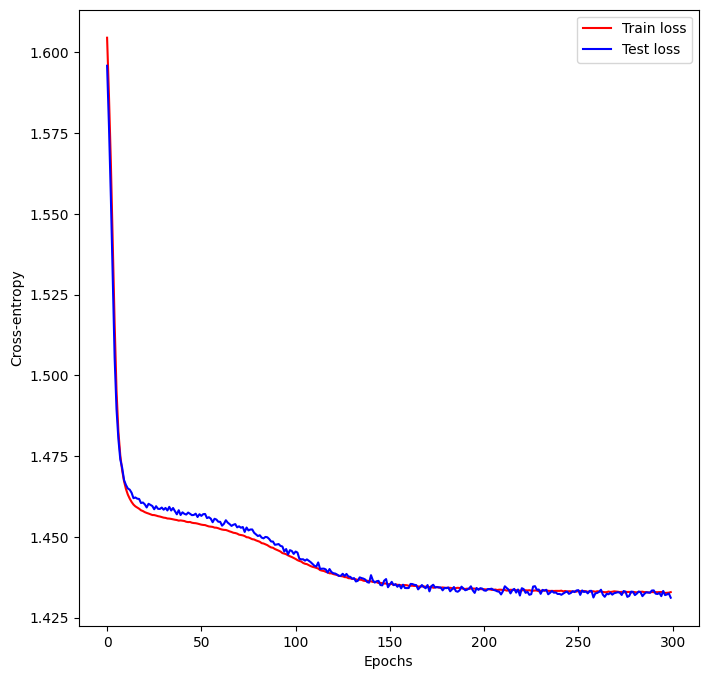

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,8))
ax.plot(train_losses, color='red', label='Train loss')
ax.plot(test_losses, color='blue', label='Test loss')
ax.legend()
ax.set_xlabel('Epochs')
ax.set_ylabel('Cross-entropy')
fig.show();

In [18]:
torch.save(network, 'model_crossentropy.pkl')

## Evaluation with accuracy

In [16]:
def evaluate(model, test_loader, device):
    model.eval()
    with torch.no_grad():
        correct = 0
        for batch_idx, batch in enumerate(test_loader):
            x = batch['dialog'].to(device)
            target = batch['act'].to(device)
            out = model(x)
            out_argmax = torch.argmax(out, dim=-1)
            correct += torch.sum( torch.where( out_argmax == target, 1, 0 ) ).item() / 5
            
    return correct / len(val_loader) / kwargs['batch_size']

In [19]:
network = torch.load('model_crossentropy.pkl')
evaluate(network, test_loader, device)

0.43596938775510197